In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = None))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.8641975308641975, Loss: 0.5498849021063911
Checkpoint 200, Accuracy: 0.8641975308641975, Loss: 0.5498849021063911
Checkpoint 300, Accuracy: 0.8641975308641975, Loss: 0.5498849021063911
Checkpoint 400, Accuracy: 0.8641975308641975, Loss: 0.5498849021063911
Checkpoint 500, Accuracy: 0.8641975308641975, Loss: 0.5498849021063911


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9404761  0.0453343  0.01418956]
[1. 0. 0.] <-> [0.9186149  0.06992424 0.01146081]
[1. 0. 0.] <-> [0.87147206 0.11568042 0.01284746]
[1. 0. 0.] <-> [0.9389531  0.05062203 0.0104249 ]
[1. 0. 0.] <-> [0.90123993 0.08637407 0.01238605]
[1. 0. 0.] <-> [0.8932522  0.08544932 0.02129847]
[1. 0. 0.] <-> [0.74761444 0.24475275 0.0076328 ]
[1. 0. 0.] <-> [0.92446536 0.06012488 0.01540967]
[0. 0. 1.] <-> [0.7402123  0.07126443 0.18852323]
[1. 0. 0.] <-> [0.9022497  0.08436666 0.01338361]
[1. 0. 0.] <-> [0.93045443 0.04100499 0.02854049]
[1. 0. 0.] <-> [0.95141035 0.03823565 0.01035397]
[1. 0. 0.] <-> [0.40707758 0.5807575  0.01216489]
[1. 0. 0.] <-> [0.89693546 0.08122347 0.02184109]
[1. 0. 0.] <-> [0.6927329  0.29557854 0.01168859]
[0. 1. 0.] <-> [0.80503184 0.08056322 0.11440502]
[1. 0. 0.] <-> [0.9350955  0.05034705 0.01455751]
[0. 1. 0.] <-> [0.18533218 0.8100538  0.00461399]
[1. 0. 0.] <-> [0.7593666  0.23198794 0.00864542]
[0. 0. 1.] <-> [0.8028263  0.055527   0.14164677]


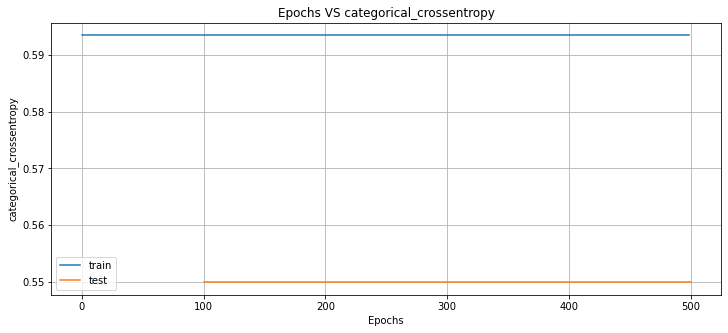

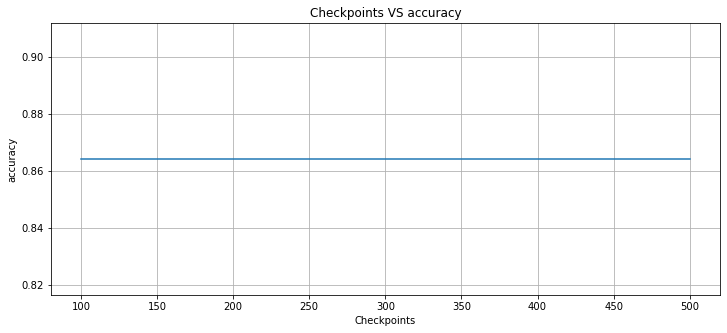

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8641975308641975, 'mean_square_error': 0.2943132386495294, 'categorical_crossentropy': 0.5498849021063911, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 20, 'tn_hit': 12, 'fn_hit': 1}, 1: {'tp_hit': 11, 'fp_hit': 2, 'tn_hit': 89, 'fn_hit': 6}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}}, 'checkpoint': 100} 


{'accuracy': 0.8641975308641975, 'mean_square_error': 0.2943132386495294, 'categorical_crossentropy': 0.5498849021063911, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 20, 'tn_hit': 12, 'fn_hit': 1}, 1: {'tp_hit': 11, 'fp_hit': 2, 'tn_hit': 89, 'fn_hit': 6}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}}, 'checkpoint': 200} 


{'accuracy': 0.8641975308641975, 'mean_square_error': 0.2943132386495294, 'categorical_crossentropy': 0.5498849021063911, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 20, 'tn_hit': 12, 'fn_hit': 1}, 1: {'tp_hit': 11, 'fp_hit': 2, 'tn_hit': 89, 'fn_hit': 6}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-1.10340009 -1.84154728  2.43775779 -1.29581627  0.38481459]
 bias: -0.5468287469822823

Neuron 1: weights:
[ 1.47086339  0.51226303 -1.42995212 -2.5278177   0.2292763 ]
 bias: 1.6695712238815297

Neuron 2: weights:
[ 2.3013101  -2.32280079 -0.25847856 -2.64450929  2.26844866]
 bias: 1.0886380500817925

Neuron 3: weights:
[ 2.02930874 -0.3642847   1.93494198  0.46089191  1.06381868]
 bias: -2.4431903789135805

$
Layer 2
Neuron 0: weights:
[-0.76664288  0.05057839  0.35778393 -1.21487674]
 bias: 1.1333773374207992

Neuron 1: weights:
[ 0.79669299 -2.13229729 -2.7106926  -0.75122136]
 bias: 2.6359409929836124

Neuron 2: weights:
[ 0.55530571 -1.1442626   0.83156199  1.46525451]
 bias: -2.9242597950402875

$

